In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('../data/credit_score_cleaned.csv')

In [5]:
df = df.drop([
    "id", "customer_id", "name", "ssn", "type_of_loan"], axis=1)
X = df.drop("credit_score", axis=1)
y = df.credit_score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
robust_columns = ['total_emi_per_month', 'amount_invested_monthly', 'monthly_balance', "annual_income", "monthly_inhand_salary"]
standard_columns = [col for col in X_train.columns if col not in robust_columns]

scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('robust', RobustScaler(), robust_columns)])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)


Explained Variance by Principal Components:
PC1: 0.7161 - Cumulative: 0.7161
PC2: 0.0550 - Cumulative: 0.7712
PC3: 0.0144 - Cumulative: 0.7856
PC4: 0.0107 - Cumulative: 0.7963
PC5: 0.0070 - Cumulative: 0.8033
PC6: 0.0070 - Cumulative: 0.8102
PC7: 0.0069 - Cumulative: 0.8172
PC8: 0.0069 - Cumulative: 0.8241
PC9: 0.0069 - Cumulative: 0.8310
PC10: 0.0069 - Cumulative: 0.8379
PC11: 0.0069 - Cumulative: 0.8447
PC12: 0.0069 - Cumulative: 0.8516
PC13: 0.0069 - Cumulative: 0.8585
PC14: 0.0069 - Cumulative: 0.8653
PC15: 0.0068 - Cumulative: 0.8722
PC16: 0.0068 - Cumulative: 0.8790
PC17: 0.0068 - Cumulative: 0.8858
PC18: 0.0068 - Cumulative: 0.8927
PC19: 0.0066 - Cumulative: 0.8993
PC20: 0.0062 - Cumulative: 0.9055
PC21: 0.0060 - Cumulative: 0.9115
PC22: 0.0060 - Cumulative: 0.9175
PC23: 0.0060 - Cumulative: 0.9235
PC24: 0.0060 - Cumulative: 0.9295
PC25: 0.0059 - Cumulative: 0.9354
PC26: 0.0059 - Cumulative: 0.9413
PC27: 0.0058 - Cumulative: 0.9471
PC28: 0.0056 - Cumulative: 0.9527
PC29: 0.0056

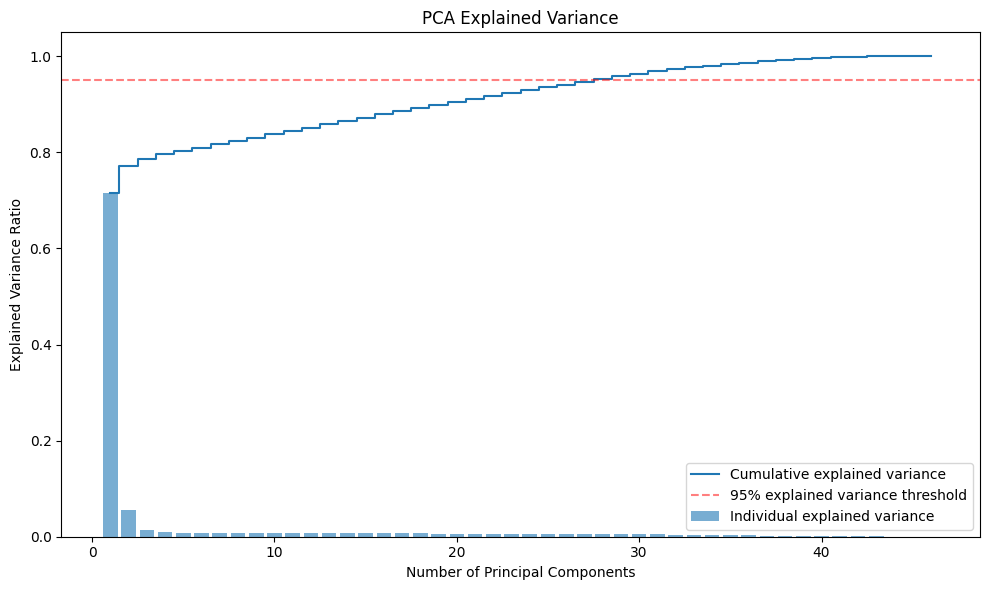


Number of components needed for 95% variance: 28

Top Contributing Features to Principal Components:

PC1 Top Features:
occupation_Media_Manager: 1.0000
occupation_Teacher: 0.0042
occupation_Scientist: 0.0042
occupation_Mechanic: 0.0036
interest_rate: -0.0027

PC2 Top Features:
num_of_delayed_payment: 0.3039
num_bank_accounts: -0.2837
total_emi_per_month: -0.2704
changed_credit_limit: -0.2669
credit_mix: -0.2639

PC3 Top Features:
occupation_Mechanic: 0.5794
occupation_Musician: 0.3834
occupation_Scientist: 0.3598
occupation_Teacher: 0.3577
outstanding_debt: 0.3480

PC4 Top Features:
credit_score: 0.4248
occupation_Musician: 0.3859
num_bank_accounts: -0.2877
outstanding_debt: 0.2619
occupation_Mechanic: -0.2302

PC5 Top Features:
mortgage_loan: 0.4241
personal_loan: -0.4062
payday_loan: 0.3230
occupation_Entrepreneur: -0.3216
occupation_Developer: 0.2766

PC6 Top Features:
mortgage_loan: 0.4504
personal_loan: 0.3450
no_loan: -0.3147
occupation_Architect: 0.2940
occupation_Doctor: -0.2

In [6]:
pca = PCA()
pca_result = pca.fit_transform(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nExplained Variance by Principal Components:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {var:.4f} - Cumulative: {cum_var:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.95, linestyle='--', color='red', alpha=0.5, label='95% explained variance threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pca_explained_variance.png')
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {n_components_95}")

num_components_to_visualize = min(6, len(explained_variance))
pca_df = pd.DataFrame(
    data=pca_result[:, :num_components_to_visualize],
    columns=[f'PC{i+1}' for i in range(num_components_to_visualize)]
)
pca_df['credit_score'] = y_train

loadings = pca.components_
feature_names = df.columns

print("\nTop Contributing Features to Principal Components:")
for i in range(num_components_to_visualize):
    loadings_pc = loadings[i]
    sorted_idx = np.argsort(np.abs(loadings_pc))[::-1]
    top_features = [(feature_names[idx], loadings_pc[idx]) for idx in sorted_idx[:5]]
    print(f"\nPC{i+1} Top Features:")
    for feature, loading in top_features:
        print(f"{feature}: {loading:.4f}")

In [8]:
pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_test_scaled)

In [9]:
model = LogisticRegression(penalty='l2')
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('Logistic Regression PCA:')
print(classification_report(y_val, y_pred, digits=4))

Logistic Regression PCA:
              precision    recall  f1-score   support

           0     0.5878    0.4299    0.4966      8246
           1     0.6146    0.7543    0.6773     15451
           2     0.5513    0.4166    0.4746      5312

    accuracy                         0.6003     29009
   macro avg     0.5846    0.5336    0.5495     29009
weighted avg     0.5954    0.6003    0.5888     29009



In [ ]:
model = DecisionTreeClassifier(max_depth=22, criterion='entropy', random_state=42)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('Decision Tree PCA:')
print(classification_report(y_val, y_pred, digits=4))

Decision Tree PCA:
              precision    recall  f1-score   support

           0     0.5299    0.5469    0.5383      3527
           1     0.6331    0.6362    0.6346      5874
           2     0.7094    0.6999    0.7046     10599

    accuracy                         0.6542     20000
   macro avg     0.6241    0.6277    0.6258     20000
weighted avg     0.6553    0.6542    0.6547     20000



In [ ]:
model = RandomForestClassifier(
    n_estimators=300,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('Random Forest PCA:')
print(classification_report(y_val, y_pred, digits=4))

Random Forest PCA:
              precision    recall  f1-score   support

           0     0.6459    0.6496    0.6477      3527
           1     0.7544    0.6849    0.7179      5874
           2     0.7526    0.7896    0.7707     10599

    accuracy                         0.7341     20000
   macro avg     0.7176    0.7080    0.7121     20000
weighted avg     0.7343    0.7341    0.7335     20000



In [ ]:
model = SVC()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('SVM PCA:')
print(classification_report(y_val, y_pred, digits=4))

SVM PCA:
              precision    recall  f1-score   support

           0     0.5077    0.7695    0.6117      3527
           1     0.6932    0.6255    0.6576      5874
           2     0.7689    0.6786    0.7209     10599

    accuracy                         0.6790     20000
   macro avg     0.6566    0.6912    0.6634     20000
weighted avg     0.7006    0.6790    0.6831     20000



In [ ]:
model = KNeighborsClassifier()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('KNN PCA:')
print(classification_report(y_val, y_pred, digits=4))

KNN PCA:
              precision    recall  f1-score   support

           0     0.5375    0.5818    0.5587      3527
           1     0.6331    0.5987    0.6155      5874
           2     0.7124    0.7143    0.7134     10599

    accuracy                         0.6570     20000
   macro avg     0.6277    0.6316    0.6292     20000
weighted avg     0.6583    0.6570    0.6573     20000



In [ ]:
model = GaussianNB()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)
print('Naive Bayes PCA:')
print(classification_report(y_val, y_pred, digits=4))

Naive Bayes PCA:
              precision    recall  f1-score   support

           0     0.4882    0.7584    0.5940      3527
           1     0.6069    0.5160    0.5578      5874
           2     0.7103    0.6385    0.6725     10599

    accuracy                         0.6237     20000
   macro avg     0.6018    0.6376    0.6081     20000
weighted avg     0.6408    0.6237    0.6250     20000

